In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.stats import pearsonr, norm
import numpy as np
from joblib import Parallel

import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from typing import Literal

In [3]:
def estimate_pvalue(
    statistic_value: float,
    statistic_array: np.ndarray,
    kind: Literal["both", "left", "right"] = "both",
) -> float:
    cdf_value = norm.cdf(
        statistic_value,
        loc=statistic_array.mean(),
        scale=statistic_array.std(),
    )
    pvalue_estimation = (
        cdf_value
        if (kind == "left")
        else (1 - cdf_value)
        if (kind == "right")
        else 2 * min(1 - cdf_value, cdf_value)
    )
    return pvalue_estimation

## Pearson correlation
First, let's estimate the p-value with bootstrapping for correlation significantly different from 0.

<Axes: >

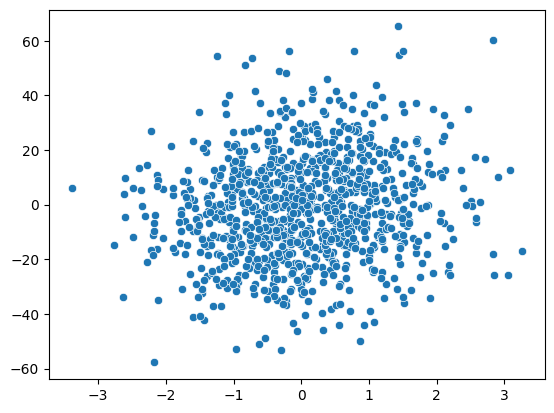

In [4]:
np.random.seed(22)

n = 1_000

x = np.random.randn(n)

rho = 0.1
scale_y = 20
epsilon = np.random.randn(n)
y = scale_y * (rho * x + np.sqrt(1 - rho**2) * epsilon)

sns.scatterplot(x=x, y=y)

In [5]:
pearsonr_exact = pearsonr(x, y)
pearsonr_exact

PearsonRResult(statistic=0.12884648297411902, pvalue=4.3805792152199106e-05)

In [6]:
n_bootstrap = 100

pearsonr_array = np.array(
    [pearsonr(x, np.random.permutation(y)).statistic for _ in range(n_bootstrap)]
)

estimate_pvalue(pearsonr_exact.statistic, pearsonr_array)

2.3237222277039393e-05

<Axes: ylabel='Density'>

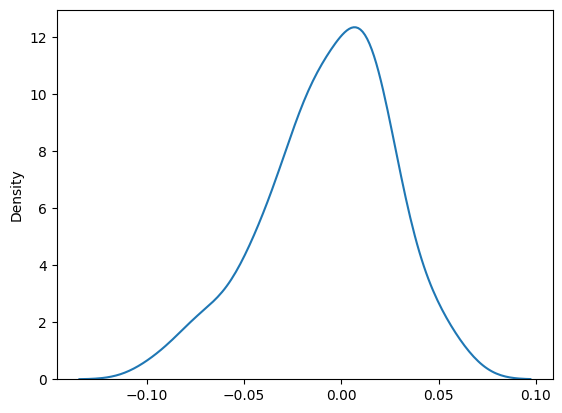

In [7]:
sns.kdeplot(pearsonr_array)

## P-value for predictiveness

<Axes: >

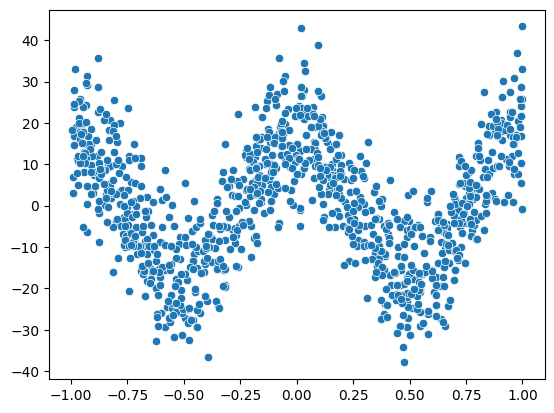

In [8]:
# Limits of pearson correlation
np.random.seed(22)

n = 1_000

x = np.random.rand(n) * 2 - 1

rho = 0.9
scale_y = 20
scale_x = 2 * np.pi
epsilon = np.random.randn(n)
y = scale_y * (rho * np.cos(scale_x * x) + np.sqrt(1 - rho**2) * epsilon)

sns.scatterplot(x=x, y=y)

In [9]:
pearsonr(x, y)

PearsonRResult(statistic=-0.01164808083122891, pvalue=0.7129504529710909)

In [10]:
def predictiveness_score(x, y, shuffle=False):
    if shuffle:
        y = np.random.permutation(y)
    return cross_val_score(
        DecisionTreeRegressor(max_depth=5), x.reshape(-1, 1), y, scoring="r2"
    ).mean()

In [11]:
np.random.seed(22)
n_bootstrap = 100

predictiveness_exact = predictiveness_score(x, y)

predictiveness_array = np.array(
    [predictiveness_score(x, np.random.permutation(y)) for _ in range(n_bootstrap)]
)

estimate_pvalue(predictiveness_exact, predictiveness_array, kind="right")

0.0

0.5548453115771059


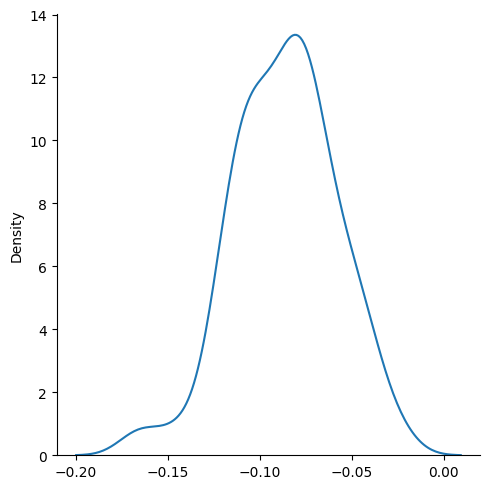

In [12]:
print(predictiveness_exact)
sns.displot(predictiveness_array, kind="kde")

In [13]:
from cc_tk.relationship.significance.predictiveness import (
    PredictivenessNumericNumeric,
    PredictivenessNumericCategorical,
)
import pandas as pd

/home/ccome/.pyenv/versions/3.12.1/envs/toolkit/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:382: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [14]:
significance = PredictivenessNumericNumeric(cv=5, n_bootstrap=100)
significance(pd.Series(x), pd.Series(y))

SignificanceOutput(pvalue=0.0, influence=Series([], dtype: object), statistic=0.5548453115771059, message='')

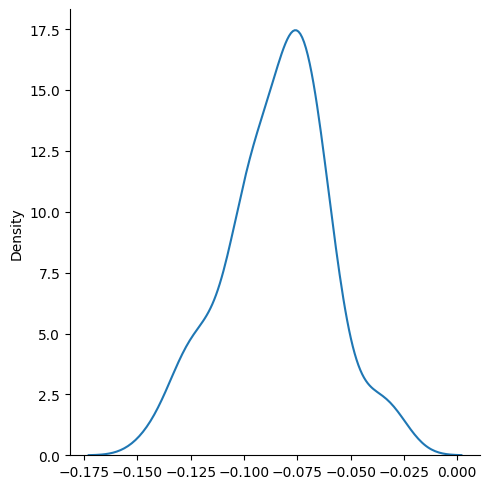

In [15]:
sns.displot(
    significance._compute_bootstrap_scores(pd.Series(x), pd.Series(y)), kind="kde"
)

<Axes: >

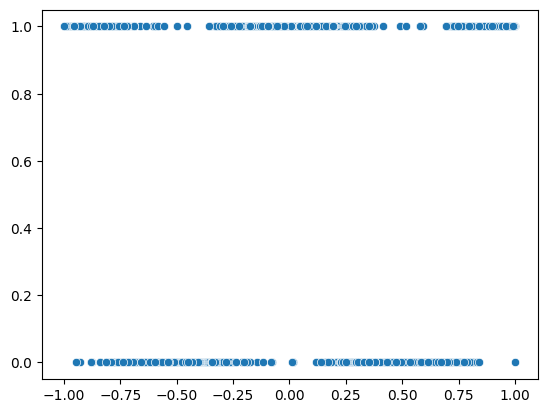

In [16]:
y_binary = (y > 0).astype(int)
sns.scatterplot(x=x, y=y_binary)

In [44]:
significance_categorical_target = PredictivenessNumericCategorical(
    # model=DecisionTreeClassifier(max_depth=5),
    model=DecisionTreeClassifier(min_impurity_decrease=0.005)
)
significance_categorical_target(pd.Series(x), pd.Series(y_binary))

SignificanceOutput(pvalue=0.0, influence=Series([], dtype: object), statistic=0.8747719933116087, message='')

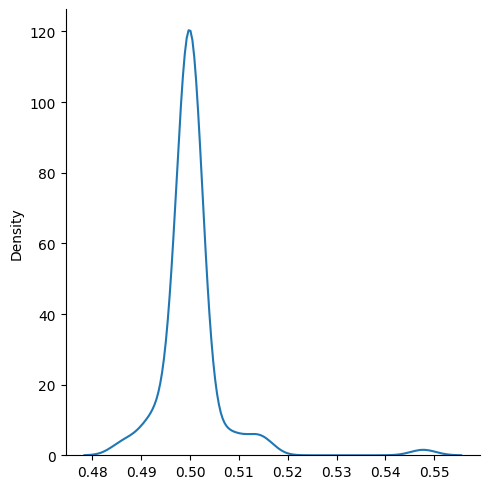

In [45]:
sns.displot(
    significance_categorical_target._compute_bootstrap_scores(
        pd.Series(x), pd.Series(y_binary)
    ),
    kind="kde",
)

In [46]:
significance_categorical_target.model.fit(x.reshape(-1, 1), pd.Series(y_binary))
significance_categorical_target.model

DecisionTreeClassifier(min_impurity_decrease=0.005)

In [48]:
from sklearn.tree import plot_tree

[Text(0.3181818181818182, 0.9285714285714286, 'x[0] <= -0.78\ngini = 0.499\nsamples = 1000\nvalue = [483, 517]'),
 Text(0.22727272727272727, 0.7857142857142857, 'gini = 0.18\nsamples = 120\nvalue = [12, 108]'),
 Text(0.4090909090909091, 0.7857142857142857, 'x[0] <= -0.298\ngini = 0.498\nsamples = 880\nvalue = [471.0, 409.0]'),
 Text(0.18181818181818182, 0.6428571428571429, 'x[0] <= -0.688\ngini = 0.245\nsamples = 231\nvalue = [198, 33]'),
 Text(0.09090909090909091, 0.5, 'gini = 0.449\nsamples = 53\nvalue = [35, 18]'),
 Text(0.2727272727272727, 0.5, 'gini = 0.154\nsamples = 178\nvalue = [163, 15]'),
 Text(0.6363636363636364, 0.6428571428571429, 'x[0] <= 0.202\ngini = 0.487\nsamples = 649\nvalue = [273, 376]'),
 Text(0.45454545454545453, 0.5, 'x[0] <= -0.233\ngini = 0.232\nsamples = 269\nvalue = [36, 233]'),
 Text(0.36363636363636365, 0.35714285714285715, 'gini = 0.48\nsamples = 25\nvalue = [15, 10]'),
 Text(0.5454545454545454, 0.35714285714285715, 'gini = 0.157\nsamples = 244\nvalue = [

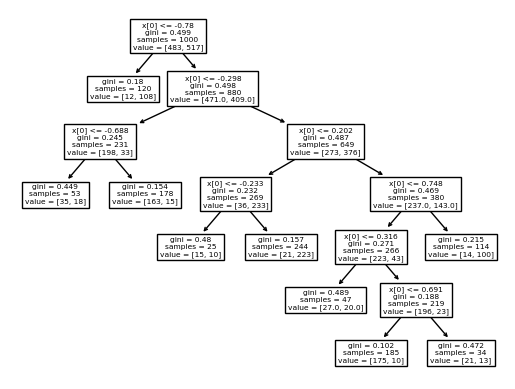

In [49]:
plot_tree(significance_categorical_target.model)